### Salary prediction, episode II: make it actually work (4 points)

Your main task is to use some of the tricks you've learned on the network and analyze if you can improve __validation MAE__. Try __at least 3 options__ from the list below for a passing grade. Write a short report about what you have tried. More ideas = more bonus points. 

__Please be serious:__ " plot learning curves in MAE/epoch, compare models based on optimal performance, test one change at a time. You know the drill :)

You can use either __pytorch__ or __tensorflow__ or any other framework (e.g. pure __keras__). Feel free to adapt the seminar code for your needs. For tensorflow version, consider `seminar_tf2.ipynb` as a starting point.


### A short report

Please tell us what you did and how did it work.

`<YOUR_TEXT_HERE>`, i guess...

## Recommended options

#### A) CNN architecture

All the tricks you know about dense and convolutional neural networks apply here as well.
* Dropout. Nuff said.
* Batch Norm. This time it's `nn.BatchNorm*`/`L.BatchNormalization`
* Parallel convolution layers. The idea is that you apply several nn.Conv1d to the same embeddings and concatenate output channels.
* More layers, more neurons, ya know...


#### B) Play with pooling

There's more than one way to perform pooling:
* Max over time (independently for each feature)
* Average over time (excluding PAD)
* Softmax-pooling:
$$ out_{i, t} = \sum_t {h_{i,t} \cdot {{e ^ {h_{i, t}}} \over \sum_\tau e ^ {h_{j, \tau}} } }$$

* Attentive pooling
$$ out_{i, t} = \sum_t {h_{i,t} \cdot Attn(h_t)}$$

, where $$ Attn(h_t) = {{e ^ {NN_{attn}(h_t)}} \over \sum_\tau e ^ {NN_{attn}(h_\tau)}}  $$
and $NN_{attn}$ is a dense layer.

The optimal score is usually achieved by concatenating several different poolings, including several attentive pooling with different $NN_{attn}$ (aka multi-headed attention).

The catch is that keras layers do not inlude those toys. You will have to [write your own keras layer](https://keras.io/layers/writing-your-own-keras-layers/). Or use pure tensorflow, it might even be easier :)

#### C) Fun with words

It's not always a good idea to train embeddings from scratch. Here's a few tricks:

* Use a pre-trained embeddings from `gensim.downloader.load`. See last lecture.
* Start with pre-trained embeddings, then fine-tune them with gradient descent. You may or may not download pre-trained embeddings from [here](http://nlp.stanford.edu/data/glove.6B.zip) and follow this [manual](https://keras.io/examples/nlp/pretrained_word_embeddings/) to initialize your Keras embedding layer with downloaded weights.
* Use the same embedding matrix in title and desc vectorizer


#### D) Going recurrent

We've already learned that recurrent networks can do cool stuff in sequence modelling. Turns out, they're not useless for classification as well. With some tricks of course..

* Like convolutional layers, LSTM should be pooled into a fixed-size vector with some of the poolings.
* Since you know all the text in advance, use bidirectional RNN
  * Run one LSTM from left to right
  * Run another in parallel from right to left 
  * Concatenate their output sequences along unit axis (dim=-1)

* It might be good idea to mix convolutions and recurrent layers differently for title and description


#### E) Optimizing seriously

* You don't necessarily need 100 epochs. Use early stopping. If you've never done this before, take a look at [early stopping callback(keras)](https://keras.io/callbacks/#earlystopping) or in [pytorch(lightning)](https://pytorch-lightning.readthedocs.io/en/latest/common/early_stopping.html).
  * In short, train until you notice that validation
  * Maintain the best-on-validation snapshot via `model.save(file_name)`
  * Plotting learning curves is usually a good idea
  
Good luck! And may the force be with you!

In [27]:
import pandas as pd
import numpy as np

import torch
import torch.nn
from torch.optim.lr_scheduler import CosineAnnealingLR, LinearLR

from sklearn.metrics import mean_absolute_error, mean_squared_error
from tqdm import tqdm
import time
from dataclasses import dataclass
from collections import OrderedDict


np.random.seed(42)
torch.manual_seed(42)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
@dataclass
class CFG:
    batch_size = 256
    
cfg = CFG()

In [3]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots

def plot_losses_metrics_and_lr(losses_dict, metrics_dict, lr_list, title):
    """
    Функция для построения графиков лоссов, метрик и learning rate.

    Параметры:
    - losses_dict: словарь лоссов, где ключ — название лосса, а значение — список значений.
    - metrics_dict: словарь метрик, где ключ — название метрики, а значение — список значений.
    - lr_list: список значений learning rate.
    - title: общее название графика.
    """
    # Создаем фигуру с тремя графиками: лоссы, метрики и learning rate
    fig = make_subplots(
        rows=3, cols=1,  # 3 строки, 1 столбец
        subplot_titles=("Losses", "Metrics", "Learning Rate"),
        vertical_spacing=0.1  # Расстояние между графиками
    )

    # Добавляем графики для лоссов
    for loss_name, loss_values in losses_dict.items():
        x_data = list(range(1, len(loss_values) + 1))  # Ось X: индекс элемента + 1
        fig.add_trace(
            go.Scatter(x=x_data, y=loss_values, mode='lines+markers', name=loss_name),
            row=1, col=1
        )

    # Добавляем графики для метрик
    for metric_name, metric_values in metrics_dict.items():
        x_data = list(range(1, len(metric_values) + 1))  # Ось X: индекс элемента + 1
        fig.add_trace(
            go.Scatter(x=x_data, y=metric_values, mode='lines+markers', name=metric_name),
            row=2, col=1
        )

    # Добавляем график для learning rate
    x_data_lr = list(range(1, len(lr_list) + 1))  # Ось X: индекс элемента + 1
    fig.add_trace(
        go.Scatter(x=x_data_lr, y=lr_list, mode='lines+markers', name="Learning Rate"),
        row=3, col=1
    )

    # Настройка макета
    fig.update_layout(
        title_text=title,  # Общее название графика
        template="plotly_white",  # Стиль графика
        showlegend=True,  # Показывать легенду
        height=800  # Высота графика
    )

    # Настройка осей
    fig.update_xaxes(title_text="Epochs", row=1, col=1)
    fig.update_yaxes(title_text="Loss Value", row=1, col=1)
    fig.update_xaxes(title_text="Epochs", row=2, col=1)
    fig.update_yaxes(title_text="Metric Value", row=2, col=1)
    fig.update_xaxes(title_text="Epochs", row=3, col=1)
    fig.update_yaxes(title_text="Learning Rate", row=3, col=1)

    # Показ графика
    fig.show()

# Preprocess data

In [4]:
data = pd.read_csv("./Train_rev1.zip", compression='zip', index_col=None)
data.shape

(244768, 12)

In [5]:
data['Log1pSalary'] = np.log1p(data['SalaryNormalized']).astype('float32')
text_columns = ["Title", "FullDescription"]
categorical_columns = ["Category", "Company", "LocationNormalized", "ContractType", "ContractTime"]
TARGET_COLUMN = "Log1pSalary"

data[categorical_columns] = data[categorical_columns].fillna('NaN') # cast missing values to string "NaN"

data.sample(3) 

Id  ... Log1pSalary
30390   68062598  ...   10.064798
108709  69622111  ...   10.045031
13924   66664026  ...   10.458838

[3 rows x 13 columns]

In [6]:
import nltk

tokenizer = nltk.tokenize.WordPunctTokenizer()

In [7]:
data['Title'] = data['Title'].astype('str').apply(lambda x: " ".join(tokenizer.tokenize(x.lower())))
data['FullDescription'] = data['FullDescription'].astype('str').apply(lambda x: " ".join(tokenizer.tokenize(x.lower())))

In [8]:
from collections import Counter
import itertools

token_counts = Counter()

# Count how many times does each token occur in both "Title" and "FullDescription" in total
token_counts.update(itertools.chain.from_iterable(data['Title'].apply(lambda x: x.split(' '))))
token_counts.update(itertools.chain.from_iterable(data['FullDescription'].apply(lambda x: x.split(' '))))

In [9]:
print("Total unique tokens :", len(token_counts))
print('\n'.join(map(str, token_counts.most_common(n=5))))
print('...')
print('\n'.join(map(str, token_counts.most_common()[-3:])))

assert token_counts.most_common(1)[0][1] in  range(2600000, 2700000)
assert len(token_counts) in range(200000, 210000)
print('Correct!')

Total unique tokens : 202704
('and', 2657388)
('.', 2523216)
(',', 2318606)
('the', 2080994)
('to', 2019884)
...
('stephanietraveltraderecruitmnt', 1)
('ruabon', 1)
('lowehays', 1)
Correct!


In [10]:
min_count = 10

# tokens from token_counts keys that had at least min_count occurrences throughout the dataset
tokens = [token for token in token_counts if token_counts[token] >= min_count]

# Add a special tokens for unknown and empty words
UNK, PAD = "UNK", "PAD"
tokens = [UNK, PAD] + tokens

In [11]:
token_to_id = {tok : i for i, tok in enumerate(tokens)}

In [12]:
UNK_IX, PAD_IX = map(token_to_id.get, [UNK, PAD])

def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    
    if isinstance(sequences[0], str):
        sequences = list(map(str.split, sequences))
    
    max_len = min(max(map(len, sequences)), max_len or float('inf'))
    
    matrix = np.full((len(sequences), max_len), np.int32(PAD_IX))
    for i,seq in enumerate(sequences):
        row_ix = [token_to_id.get(word, UNK_IX) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix
    
    return matrix

In [13]:
print("Lines:")
print('\n'.join(data["Title"][::100000].values), end='\n\n')
print("Matrix:")
print(as_matrix(data["Title"][::100000]))

Lines:
engineering systems analyst
hr assistant
senior ec & i engineer

Matrix:
[[   2    3    4    1    1]
 [ 998  176    1    1    1]
 [  18 3472  242   59    6]]


In [14]:
from sklearn.feature_extraction import DictVectorizer

# we only consider top-1k most frequent companies to minimize memory usage
top_companies, top_counts = zip(*Counter(data['Company']).most_common(1000))
recognized_companies = set(top_companies)
data["Company"] = data["Company"].apply(lambda comp: comp if comp in recognized_companies else "Other")

categorical_vectorizer = DictVectorizer(dtype=np.float32, sparse=False)
categorical_vectorizer.fit(data[categorical_columns].apply(dict, axis=1))

DictVectorizer(dtype=<class 'numpy.float32'>, sparse=False)

In [15]:
from sklearn.model_selection import train_test_split

data_train, data_val = train_test_split(data, test_size=0.2, random_state=42)
data_train.index = range(len(data_train))
data_val.index = range(len(data_val))

print("Train size = ", len(data_train))
print("Validation size = ", len(data_val))

Train size =  195814
Validation size =  48954


In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F


def to_tensors(batch, device):
    batch_tensors = dict()
    for key, arr in batch.items():
        if key in ["FullDescription", "Title"]:
            batch_tensors[key] = torch.tensor(arr, device=device, dtype=torch.int64)
        else:
            batch_tensors[key] = torch.tensor(arr, device=device)
    return batch_tensors


def make_batch(data, max_len=None, word_dropout=0, device=device):
    """
    Creates a keras-friendly dict from the batch data.
    :param word_dropout: replaces token index with UNK_IX with this probability
    :returns: a dict with {'title' : int64[batch, title_max_len]
    """
    batch = {}
    batch["Title"] = as_matrix(data["Title"].values, max_len)
    batch["FullDescription"] = as_matrix(data["FullDescription"].values, max_len)
    batch['Categorical'] = categorical_vectorizer.transform(data[categorical_columns].apply(dict, axis=1))
    
    if word_dropout != 0:
        batch["FullDescription"] = apply_word_dropout(batch["FullDescription"], 1. - word_dropout)
    
    if TARGET_COLUMN in data.columns:
        batch[TARGET_COLUMN] = data[TARGET_COLUMN].values
    
    return to_tensors(batch, device)

def apply_word_dropout(matrix, keep_prop, replace_with=UNK_IX, pad_ix=PAD_IX,):
    dropout_mask = np.random.choice(2, np.shape(matrix), p=[keep_prop, 1 - keep_prop])
    dropout_mask &= matrix != pad_ix
    return np.choose(dropout_mask, [matrix, np.full_like(matrix, replace_with)])

# Training model

In [17]:
def make_minibatch(data, batch_size=cfg.batch_size, shuffle=False):
    indices = np.arange(len(data))
    
    if shuffle:
        np.random.shuffle(indices)
    
    for idx in range(0, len(data), batch_size):
        yield indices[idx : idx+batch_size]

In [18]:
def train_epoch(data, model, loss_fn, optimizer):
    losses = []
    model.train()
    for indices in tqdm(make_minibatch(data), total=data.shape[0] / cfg.batch_size):
        optimizer.zero_grad()
        batch = make_batch(data.loc[indices])
        
        predict = model(batch)
        loss = loss_fn(predict, batch['Log1pSalary'])
        loss.backward()
        losses.append(loss.item())
        optimizer.step()
        
    return np.asarray(losses).sum()

In [19]:
def val_epoch(data, model, loss_fn):
    model.eval()
    losses = []
    sample_size = 0
    mse = 0
    mae = 0
    with torch.no_grad():
        for indices in tqdm(make_minibatch(data), total=data.shape[0] / cfg.batch_size):
            batch = make_batch(data.loc[indices])
            predict = model(batch)
            loss = loss_fn(predict, batch['Log1pSalary'])
            losses.append(loss.item())
            mse += torch.square(predict - batch['Log1pSalary']).sum()
            mae += torch.abs(predict - batch['Log1pSalary']).sum()
            sample_size += len(predict)

    return np.asarray(losses).sum(), mse.cpu() / sample_size, mae.cpu() / sample_size

In [20]:
from collections import defaultdict

def model_training(
    model, 
    loss,
    optimizer,
    device,
    lr_scheduler=None,
    num_epochs=3
):
    model.to(device)
    
    losses = defaultdict(list)
    metrics = defaultdict(list)
    learning_rates = []
    for epoch in range(1, num_epochs+1):
        print('------------------------')
        print(f'Training epoch {epoch}')
        start = time.time()
        losses['train'].append(train_epoch(data_train, model, loss, optimizer))
        end = time.time()
        if lr_scheduler:
            lr_scheduler.step()
            learning_rates.append(lr_scheduler.get_last_lr()[0])
        else:
            learning_rates.append(learning_rates[-1])
        print(f'end of training epoch {epoch}, it took {end - start:.20f} seconds')
        
        
        print(f'Eval epoch {epoch}')
        start = time.time()
        eval_loss, mse, mae = val_epoch(data_val, model, loss)
        end = time.time()
        print(f'end of eval epoch {epoch}, it took {end - start:.20f} seconds')
        
        metrics['mae'].append(mae)
        metrics['mse'].append(mse)
        losses['eval'].append(eval_loss)
        print(learning_rates, epoch, 'this is lr')
        plot_losses_metrics_and_lr(losses, metrics, learning_rates, 'Простая сверточная модель')
    return losses, metrics

# CNN network without pretrained embeds and any dropouts

In [21]:
class CNN_model(nn.Module):
    def __init__(self, embded_size=300, kernel_size=3, hidden_size=64, categorical_size=3768):
        super().__init__()
        self.embed_size = 300
        self.kernel_size = kernel_size
        self.hidden_size = hidden_size
        self.categical_size = categorical_size
        
        self.embed = nn.Embedding(len(token_to_id), self.embed_size, token_to_id['PAD'])
        self.CNN = nn.Conv1d(self.embed_size, self.hidden_size, self.kernel_size)
        
        self.categorial_extractor = nn.Sequential(OrderedDict([
            ('linear1', nn.Linear(self.categical_size, 1000)),
            ('ReLU', nn.ReLU()),
            ('linear2', nn.Linear(1000, self.hidden_size))
        ])
        )
        
        self.fc = nn.Sequential(OrderedDict([
            ('linear1', nn.Linear(3 * self.hidden_size, 1000)),
            ('ReLU', nn.ReLU()),
            ('linear2', nn.Linear(1000, 50))
        ])
        )
    
    def forward(self, x):
        title_features = torch.max(self.CNN(self.embed(x['Title']).transpose(1, 2)), dim=-1).values
        desc_features = torch.max(self.CNN(self.embed(x['FullDescription']).transpose(1, 2)), dim=-1).values
        cat_features = self.categorial_extractor(x['Categorical'])
        features = torch.cat([title_features, desc_features, cat_features], dim=-1)
        
        preds = self.fc(features)
        return preds.sum(dim=-1)

In [ ]:
model = CNN_model().to(device)

In [ ]:
model = CNN_model()

loss = nn.MSELoss('sum')
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)


losses, metrics = model_training(model, loss, optimizer, device, num_epochs=10)

In [ ]:
plot_losses_and_metrics(losses, metrics, 'Простая сверточная модель')

# CNN model with dropout and batchnorm

In [67]:
class CNN_model_and_dropout(nn.Module):
    def __init__(self, embded_size=300, kernel_size=3, hidden_size=64, categorical_size=3768):
        super().__init__()
        self.embed_size = 300
        self.kernel_size = kernel_size
        self.hidden_size = hidden_size
        self.categical_size = categorical_size
        
        self.embed = nn.Embedding(len(token_to_id), self.embed_size, token_to_id['PAD'])
        self.CNN = nn.Conv1d(self.embed_size, self.hidden_size, self.kernel_size)
        
        self.categorial_extractor = nn.Sequential(OrderedDict([
            ('linear1', nn.Linear(self.categical_size, 1000)),
            ('batchnorm', nn.BatchNorm1d(1000)),
            ('ReLU', nn.ReLU()),
            ('dropout', nn.Dropout1d(p=0.2)),
            ('linear2', nn.Linear(1000, self.hidden_size))
        ])
        )
        
        self.fc = nn.Sequential(OrderedDict([
            ('linear1', nn.Linear(3 * self.hidden_size, 1000)),
            ('batchnorm', nn.BatchNorm1d(1000)),
            ('ReLU', nn.ReLU()),
            ('dropout', nn.Dropout1d(p=0.2)),
            ('linear2', nn.Linear(1000, 50))
        ])
        )
    
    def forward(self, x):
        title_features = torch.max(self.CNN(self.embed(x['Title']).transpose(1, 2)), dim=-1).values
        desc_features = torch.max(self.CNN(self.embed(x['FullDescription']).transpose(1, 2)), dim=-1).values
        cat_features = self.categorial_extractor(x['Categorical'])
        features = torch.cat([title_features, desc_features, cat_features], dim=-1)
        
        preds = self.fc(features)
        return preds.sum(dim=-1)

/home/jupyter/.local/lib/python3.10/site-packages/torch/nn/_reduction.py:42: UserWarning:

size_average and reduce args will be deprecated, please use reduction='mean' instead.



------------------------
Training epoch 1


100%|█████████▉| 763/764.8984375 [01:01<00:00, 11.96it/s]/home/jupyter/.local/lib/python3.10/site-packages/tqdm/std.py:636: TqdmWarning:

clamping frac to range [0, 1]

100%|██████████| 765/764.8984375 [01:01<00:00, 12.44it/s]


end of training epoch 1, it took 61.48171019554138183594 seconds
Eval epoch 1


192it [00:08, 23.05it/s]                                 

end of eval epoch 1, it took 8.33271646499633789062 seconds
[7.500000000000001e-05] 1 this is lr


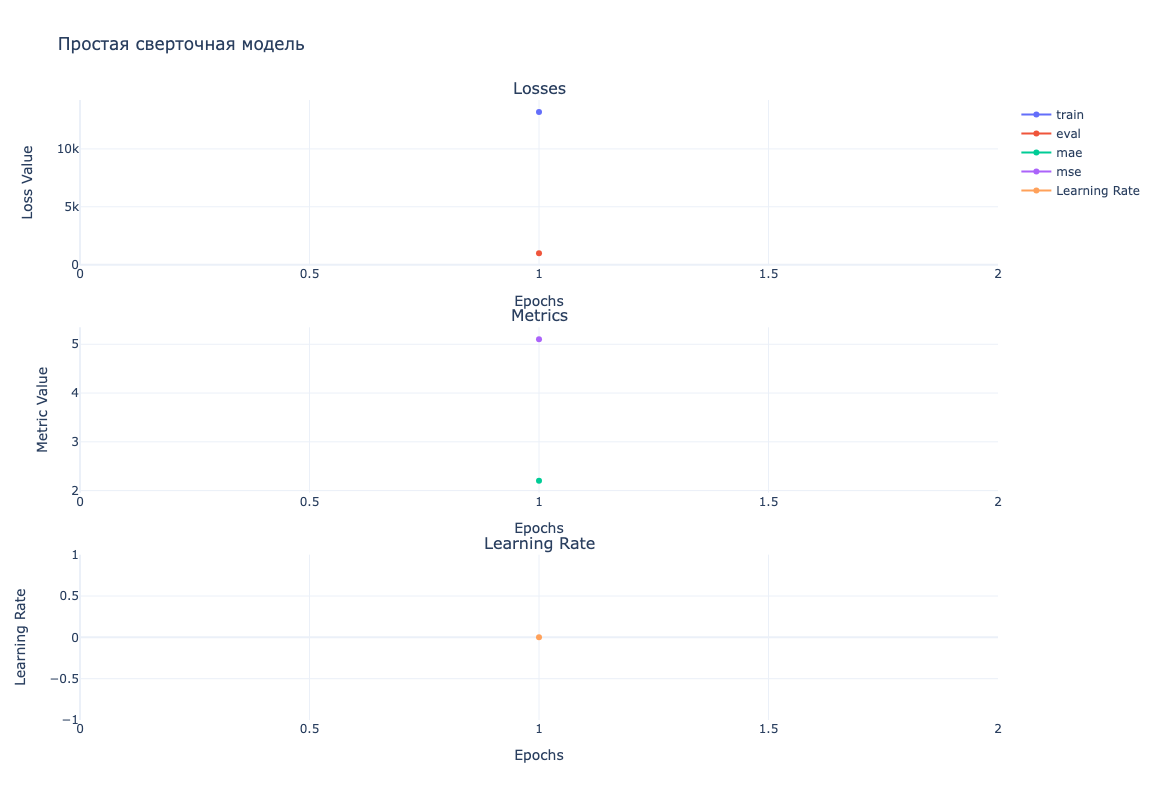

------------------------
Training epoch 2


100%|█████████▉| 764/764.8984375 [01:02<00:00, 12.53it/s]/home/jupyter/.local/lib/python3.10/site-packages/tqdm/std.py:636: TqdmWarning:

clamping frac to range [0, 1]

100%|██████████| 765/764.8984375 [01:02<00:00, 12.30it/s]


end of training epoch 2, it took 62.21646404266357421875 seconds
Eval epoch 2


192it [00:08, 23.54it/s]                                 

end of eval epoch 2, it took 8.15855622291564941406 seconds
[7.500000000000001e-05, 2.5000000000000015e-05] 2 this is lr


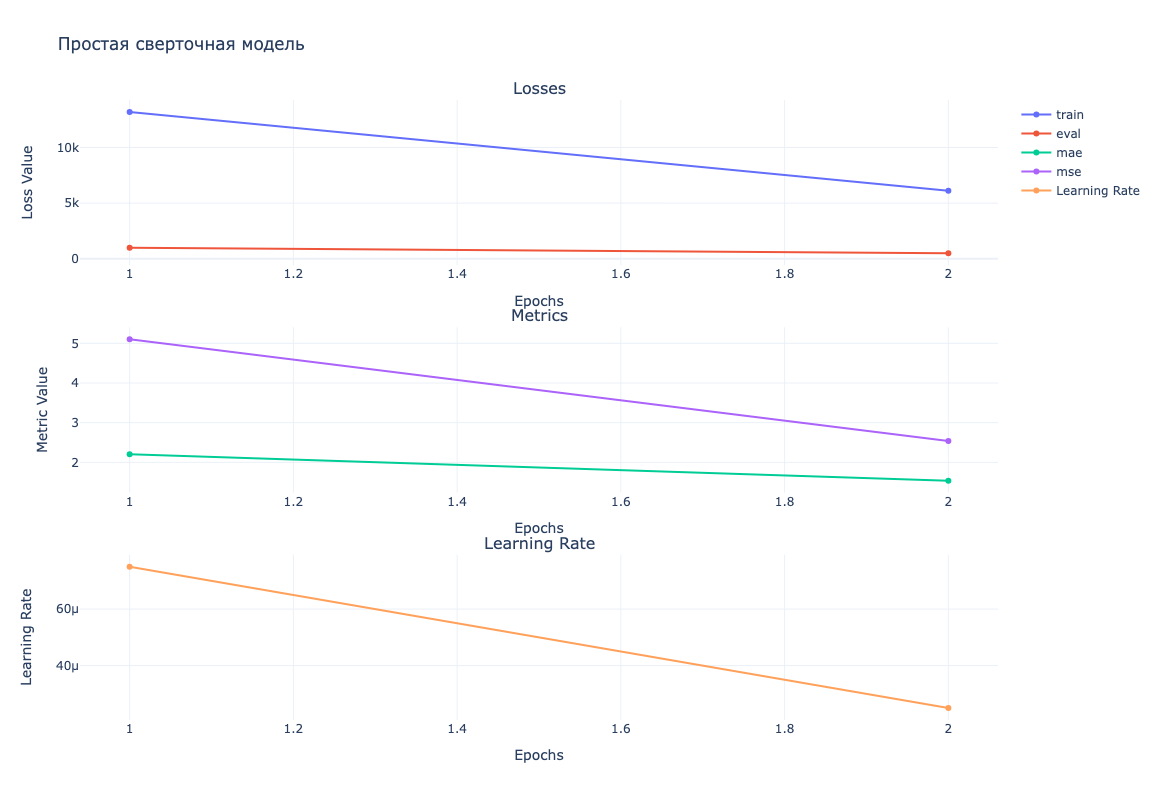

------------------------
Training epoch 3


100%|█████████▉| 764/764.8984375 [01:02<00:00, 12.43it/s]/home/jupyter/.local/lib/python3.10/site-packages/tqdm/std.py:636: TqdmWarning:

clamping frac to range [0, 1]

100%|██████████| 765/764.8984375 [01:02<00:00, 12.31it/s]


end of training epoch 3, it took 62.13249802589416503906 seconds
Eval epoch 3


192it [00:08, 22.51it/s]                                 

end of eval epoch 3, it took 8.53366494178771972656 seconds
[7.500000000000001e-05, 2.5000000000000015e-05, 0.0] 3 this is lr


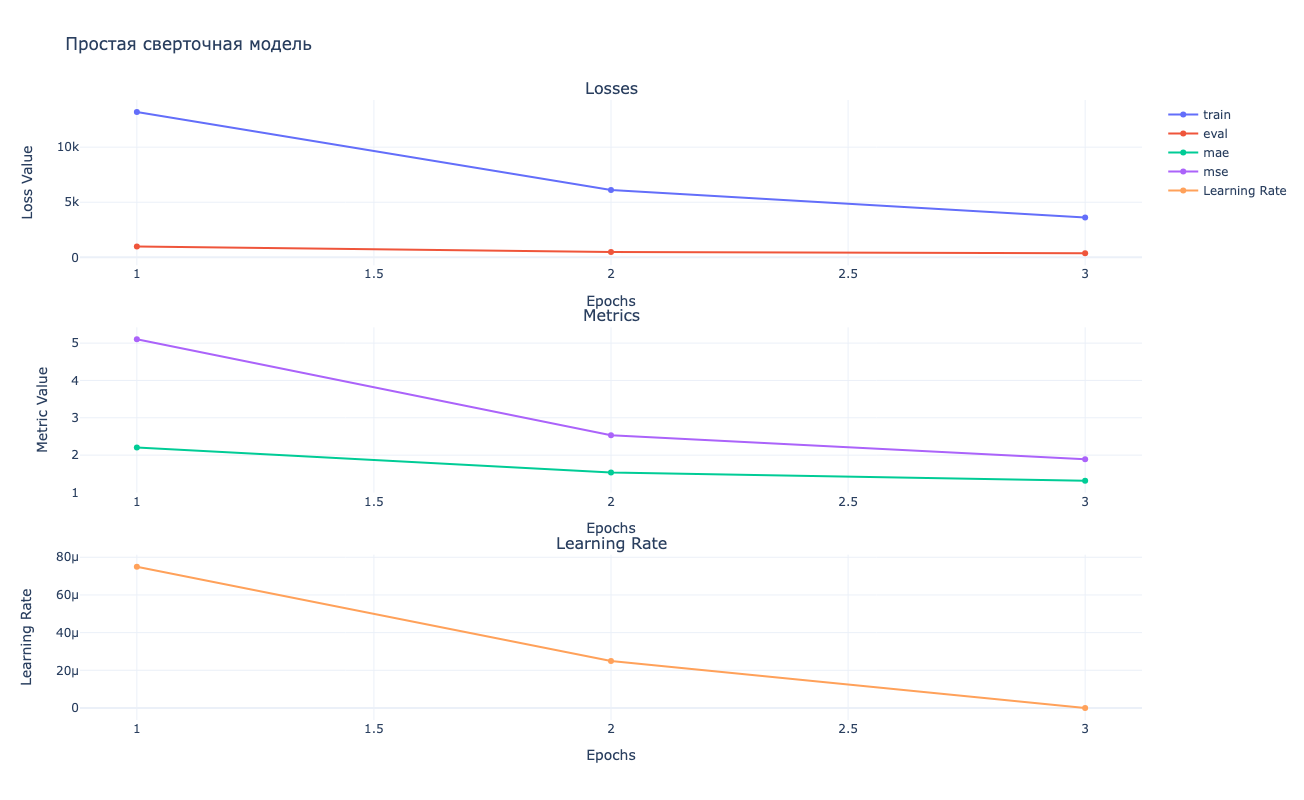

------------------------
Training epoch 4


100%|█████████▉| 764/764.8984375 [01:02<00:00, 12.40it/s]/home/jupyter/.local/lib/python3.10/site-packages/tqdm/std.py:636: TqdmWarning:

clamping frac to range [0, 1]

100%|██████████| 765/764.8984375 [01:02<00:00, 12.21it/s]


end of training epoch 4, it took 62.65327095985412597656 seconds
Eval epoch 4


192it [00:08, 22.93it/s]                                 

end of eval epoch 4, it took 8.37693119049072265625 seconds
[7.500000000000001e-05, 2.5000000000000015e-05, 0.0, 2.4999999999999994e-05] 4 this is lr


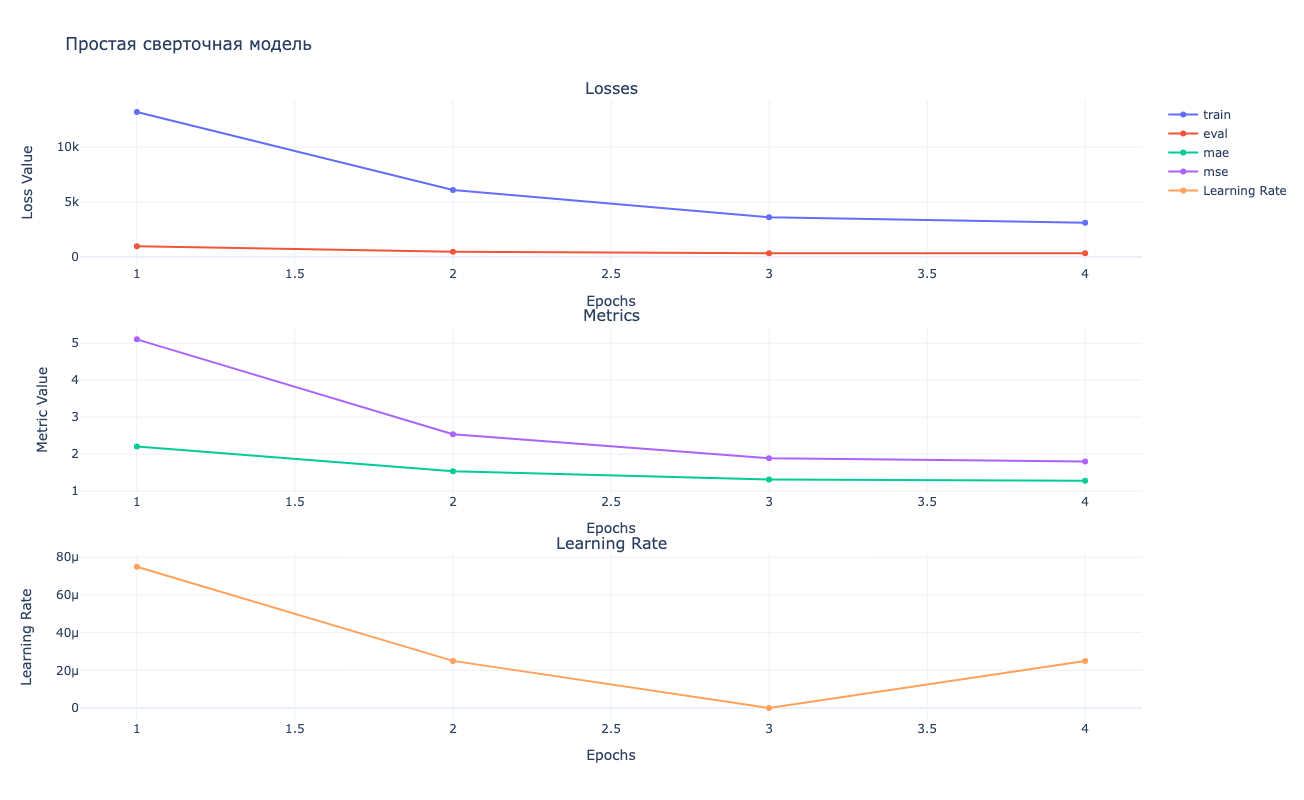

------------------------
Training epoch 5


100%|█████████▉| 764/764.8984375 [01:02<00:00, 12.44it/s]/home/jupyter/.local/lib/python3.10/site-packages/tqdm/std.py:636: TqdmWarning:

clamping frac to range [0, 1]

100%|██████████| 765/764.8984375 [01:02<00:00, 12.20it/s]


end of training epoch 5, it took 62.71548628807067871094 seconds
Eval epoch 5


192it [00:08, 23.14it/s]                                 

end of eval epoch 5, it took 8.30013322830200195312 seconds
[7.500000000000001e-05, 2.5000000000000015e-05, 0.0, 2.4999999999999994e-05, 7.500000000000005e-05] 5 this is lr


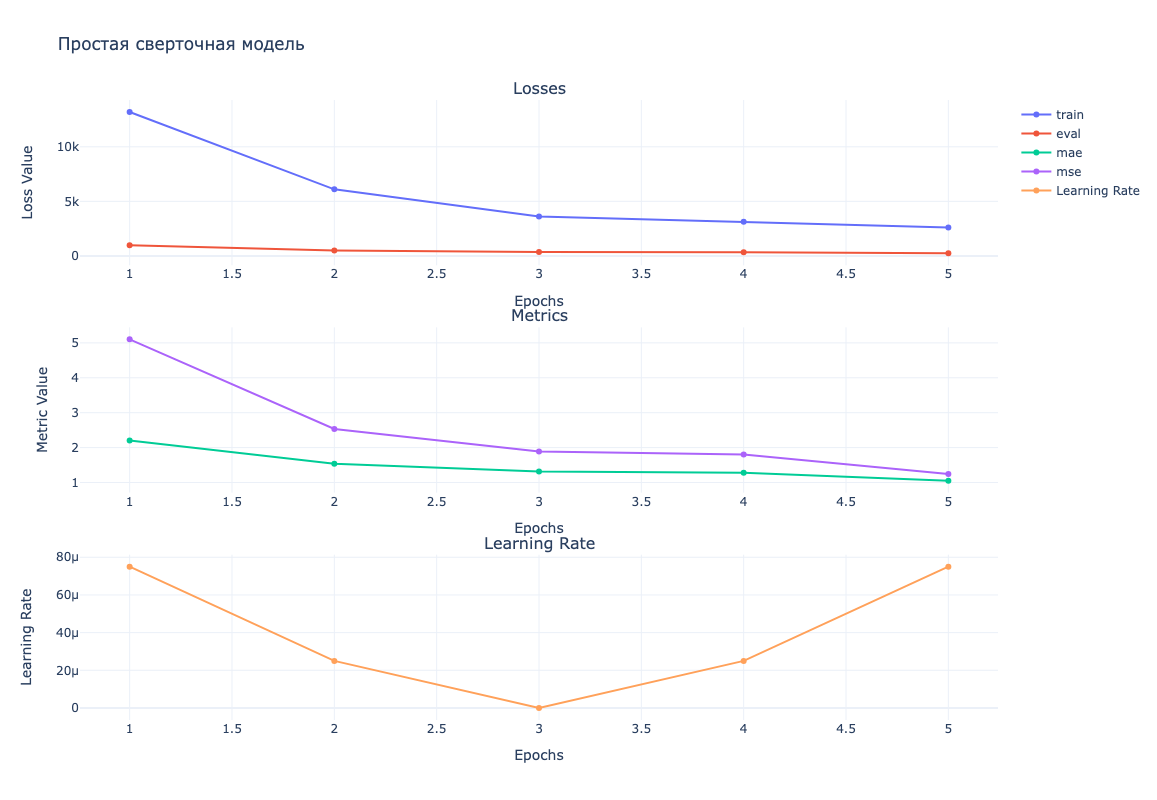

------------------------
Training epoch 6


100%|█████████▉| 764/764.8984375 [01:02<00:00, 12.47it/s]/home/jupyter/.local/lib/python3.10/site-packages/tqdm/std.py:636: TqdmWarning:

clamping frac to range [0, 1]

100%|██████████| 765/764.8984375 [01:02<00:00, 12.25it/s]


end of training epoch 6, it took 62.46046710014343261719 seconds
Eval epoch 6


192it [00:08, 23.38it/s]                                 

end of eval epoch 6, it took 8.21732425689697265625 seconds
[7.500000000000001e-05, 2.5000000000000015e-05, 0.0, 2.4999999999999994e-05, 7.500000000000005e-05, 0.00010000000000000006] 6 this is lr


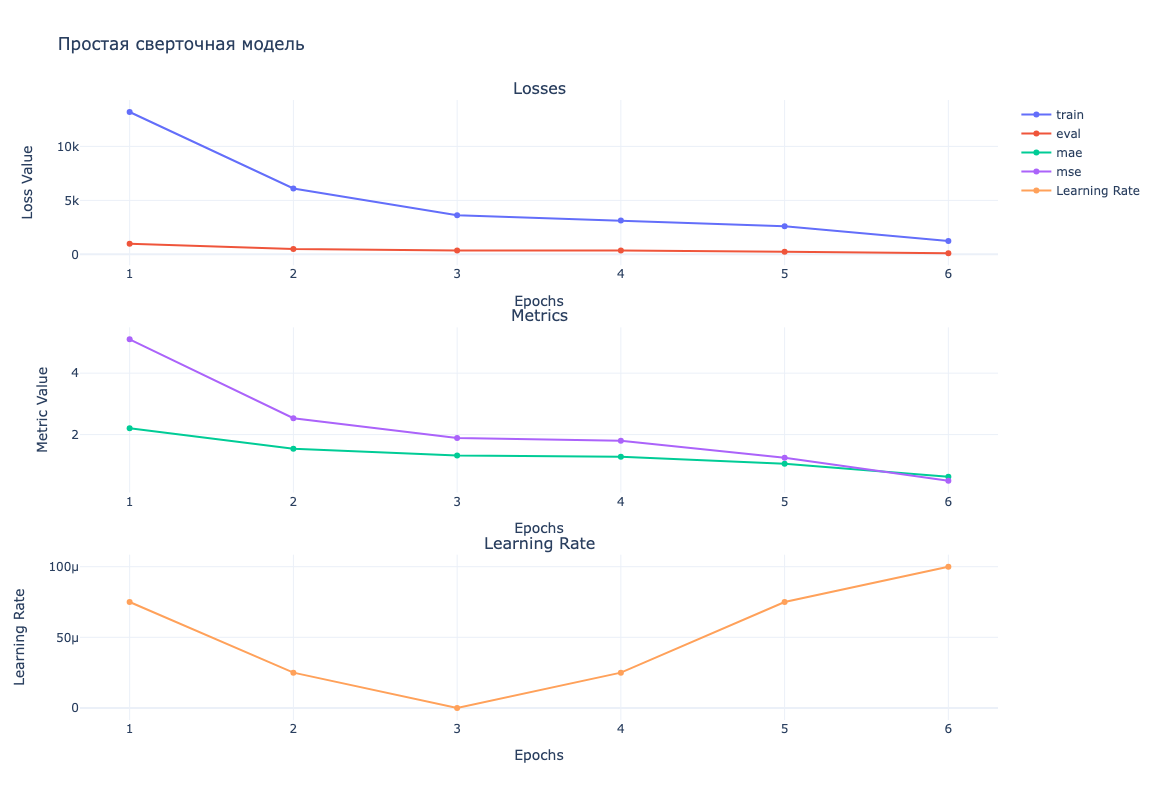

------------------------
Training epoch 7


100%|█████████▉| 764/764.8984375 [01:02<00:00, 12.38it/s]/home/jupyter/.local/lib/python3.10/site-packages/tqdm/std.py:636: TqdmWarning:

clamping frac to range [0, 1]

100%|██████████| 765/764.8984375 [01:02<00:00, 12.22it/s]


end of training epoch 7, it took 62.59998488426208496094 seconds
Eval epoch 7


192it [00:08, 23.32it/s]                                 

end of eval epoch 7, it took 8.23732018470764160156 seconds
[7.500000000000001e-05, 2.5000000000000015e-05, 0.0, 2.4999999999999994e-05, 7.500000000000005e-05, 0.00010000000000000006, 7.500000000000006e-05] 7 this is lr


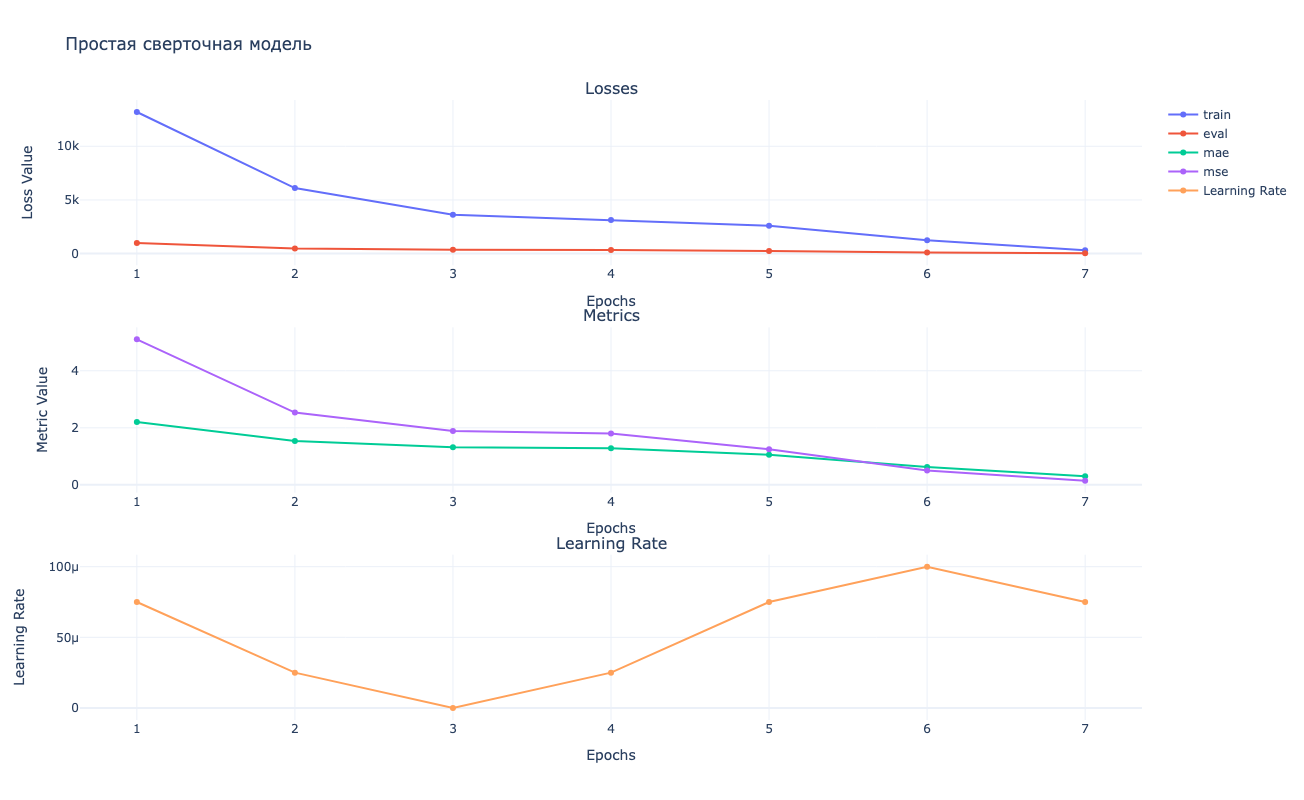

------------------------
Training epoch 8


100%|█████████▉| 764/764.8984375 [01:02<00:00, 12.46it/s]/home/jupyter/.local/lib/python3.10/site-packages/tqdm/std.py:636: TqdmWarning:

clamping frac to range [0, 1]

100%|██████████| 765/764.8984375 [01:02<00:00, 12.26it/s]


end of training epoch 8, it took 62.41751265525817871094 seconds
Eval epoch 8


192it [00:08, 22.95it/s]                                 

end of eval epoch 8, it took 8.37093472480773925781 seconds
[7.500000000000001e-05, 2.5000000000000015e-05, 0.0, 2.4999999999999994e-05, 7.500000000000005e-05, 0.00010000000000000006, 7.500000000000006e-05, 2.5000000000000052e-05] 8 this is lr


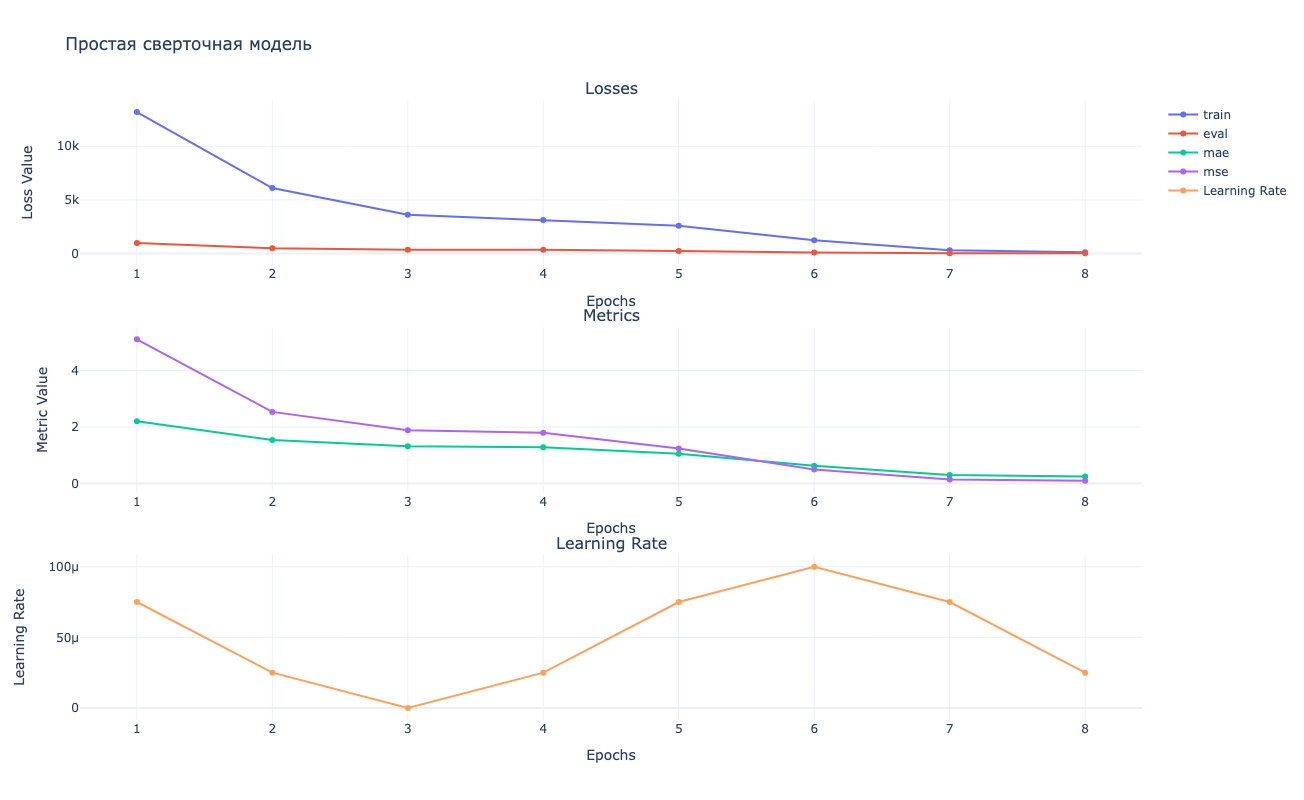

------------------------
Training epoch 9


100%|█████████▉| 764/764.8984375 [01:02<00:00, 12.36it/s]/home/jupyter/.local/lib/python3.10/site-packages/tqdm/std.py:636: TqdmWarning:

clamping frac to range [0, 1]

100%|██████████| 765/764.8984375 [01:03<00:00, 12.14it/s]


end of training epoch 9, it took 63.02584695816040039062 seconds
Eval epoch 9


192it [00:08, 22.58it/s]                                 

end of eval epoch 9, it took 8.50523734092712402344 seconds
[7.500000000000001e-05, 2.5000000000000015e-05, 0.0, 2.4999999999999994e-05, 7.500000000000005e-05, 0.00010000000000000006, 7.500000000000006e-05, 2.5000000000000052e-05, 0.0] 9 this is lr


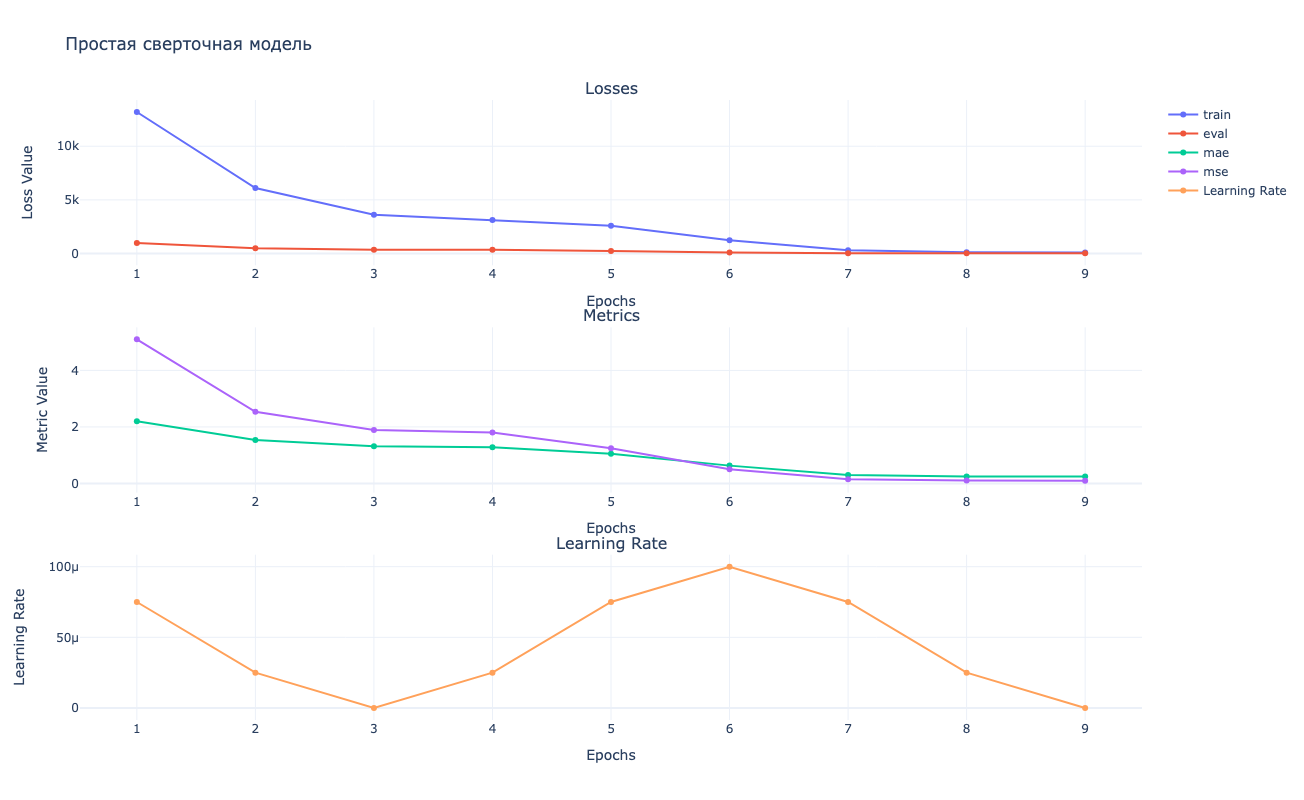

------------------------
Training epoch 10


100%|█████████▉| 764/764.8984375 [01:02<00:00, 12.33it/s]/home/jupyter/.local/lib/python3.10/site-packages/tqdm/std.py:636: TqdmWarning:

clamping frac to range [0, 1]

100%|██████████| 765/764.8984375 [01:02<00:00, 12.18it/s]


end of training epoch 10, it took 62.82730698585510253906 seconds
Eval epoch 10


192it [00:08, 22.75it/s]                                 

end of eval epoch 10, it took 8.44283652305603027344 seconds
[7.500000000000001e-05, 2.5000000000000015e-05, 0.0, 2.4999999999999994e-05, 7.500000000000005e-05, 0.00010000000000000006, 7.500000000000006e-05, 2.5000000000000052e-05, 0.0, 2.4999999999999994e-05] 10 this is lr


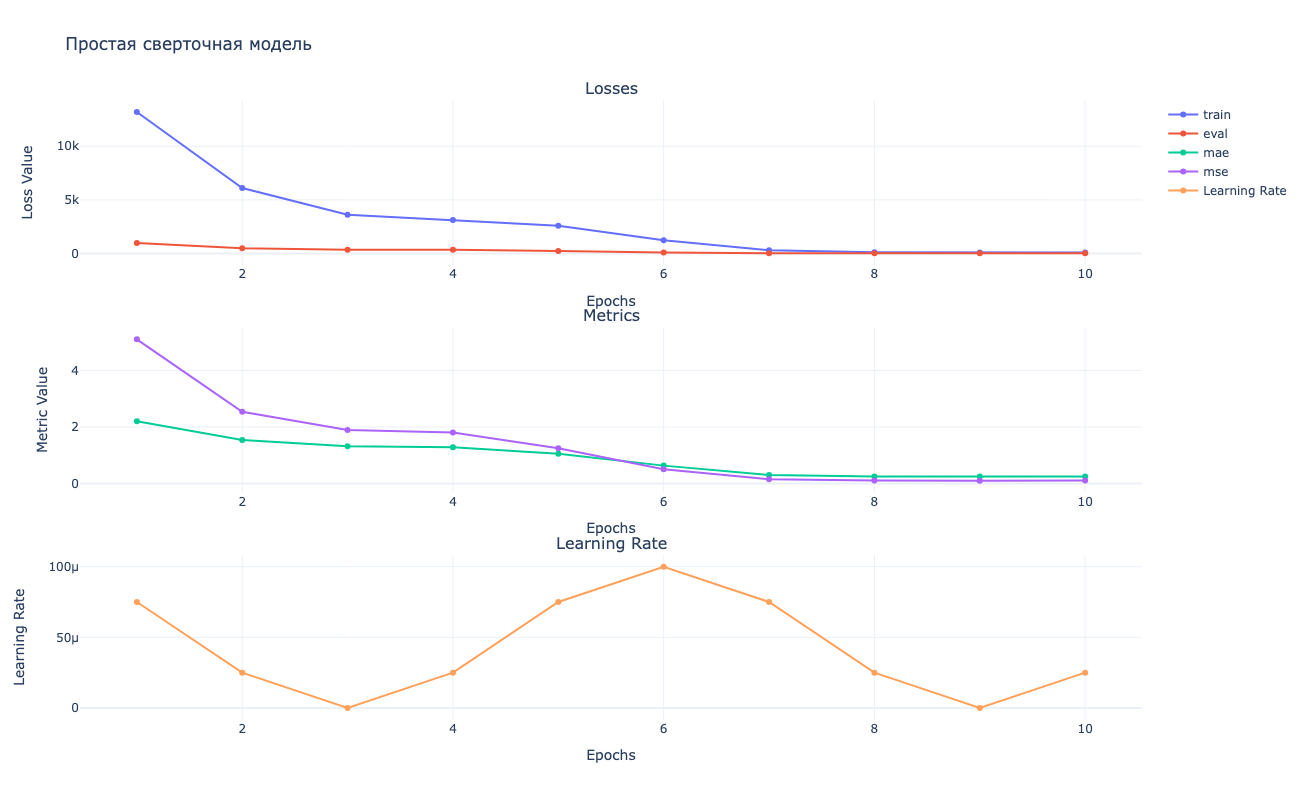

In [68]:
model = CNN_model_and_dropout()

loss = nn.MSELoss('sum')
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
lr_scheduler = CosineAnnealingLR(optimizer, 3)

losses, metrics = model_training(model, loss, optimizer, device, lr_scheduler, num_epochs=10)

# CNN with pre-trained embeds

In [21]:
from gensim.models import Word2Vec
import gensim.downloader as api

model_glove_vec = api.load('glove-wiki-gigaword-300')

In [22]:
def create_weights_from_pretrained(model, vocab):
    weights = []
    
    for tok in vocab:
        if tok in model.key_to_index:
            weights.append(model.get_vector(tok))
        else:
            weights.append(np.random.normal(loc=0, scale=1, size=model.vector_size))
    return torch.stack([torch.from_numpy(weight) for weight in weights], dim=0)

In [23]:
pretrained_weights = create_weights_from_pretrained(model_glove_vec, tokens)
pretrained_weights = pretrained_weights.type(torch.float32)

/tmp/ipykernel_12579/561711151.py:9: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  return torch.stack([torch.from_numpy(weight) for weight in weights], dim=0)


In [24]:
assert pretrained_weights.shape[0] == len(tokens)
assert torch.equal(pretrained_weights[token_to_id['the']], torch.tensor(model_glove_vec.get_vector('the')))

In [86]:
class CNN_model_pre_trained_weights(nn.Module):
    def __init__(self, embded_size=300, kernel_size=3, hidden_size=64, categorical_size=3768):
        super().__init__()
        self.embed_size = 300
        self.kernel_size = kernel_size
        self.hidden_size = hidden_size
        self.categical_size = categorical_size
        
        self.embed = nn.Embedding.from_pretrained(pretrained_weights, freeze=False, padding_idx=token_to_id['PAD'])
        self.CNN = nn.Conv1d(self.embed_size, self.hidden_size, self.kernel_size)
        
        self.categorial_extractor = nn.Sequential(OrderedDict([
            ('linear1', nn.Linear(self.categical_size, 1000)),
            ('batchnorm', nn.BatchNorm1d(1000)),
            ('ReLU', nn.ReLU()),
            ('dropout', nn.Dropout1d(p=0.2)),
            ('linear2', nn.Linear(1000, self.hidden_size))
        ])
        )
        
        self.fc = nn.Sequential(OrderedDict([
            ('linear1', nn.Linear(3 * self.hidden_size, 1000)),
            ('batchnorm', nn.BatchNorm1d(1000)),
            ('ReLU', nn.ReLU()),
            ('dropout', nn.Dropout1d(p=0.2)),
            ('linear2', nn.Linear(1000, 50))
        ])
        )
    
    def forward(self, x):
        title_features = torch.max(self.CNN(self.embed(x['Title']).transpose(1, 2)), dim=-1).values
        desc_features = torch.max(self.CNN(self.embed(x['FullDescription']).transpose(1, 2)), dim=-1).values
        cat_features = self.categorial_extractor(x['Categorical'])
        features = torch.cat([title_features, desc_features, cat_features], dim=-1)
        
        preds = self.fc(features)
        return preds.sum(dim=-1)

/home/jupyter/.local/lib/python3.10/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


------------------------
Training epoch 1


100%|█████████▉| 764/764.8984375 [01:02<00:00, 12.47it/s]/home/jupyter/.local/lib/python3.10/site-packages/tqdm/std.py:636: TqdmWarning: clamping frac to range [0, 1]
  full_bar = Bar(frac,
100%|██████████| 765/764.8984375 [01:02<00:00, 12.25it/s]


end of training epoch 1, it took 62.46941971778869628906 seconds
Eval epoch 1


192it [00:08, 22.56it/s]                                 

end of eval epoch 1, it took 8.51447439193725585938 seconds
[0.000225] 1 this is lr


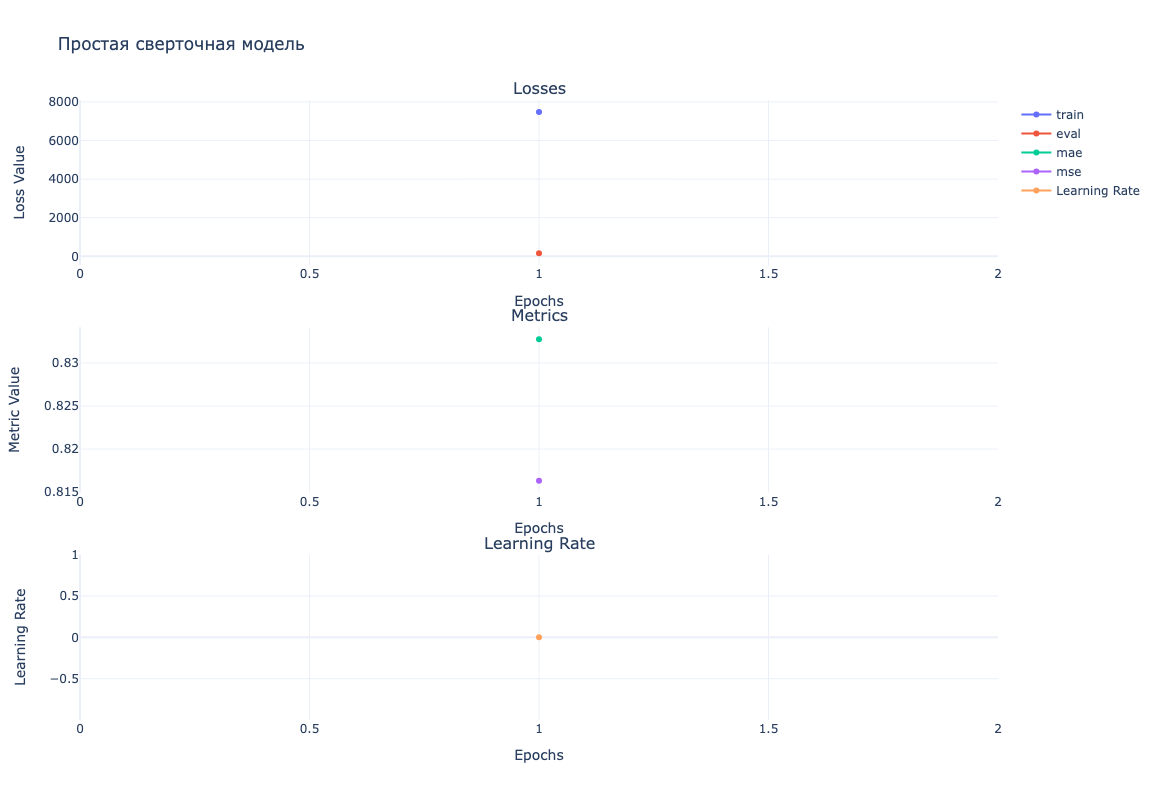

------------------------
Training epoch 2


100%|█████████▉| 764/764.8984375 [01:02<00:00, 12.28it/s]/home/jupyter/.local/lib/python3.10/site-packages/tqdm/std.py:636: TqdmWarning:

clamping frac to range [0, 1]

100%|██████████| 765/764.8984375 [01:02<00:00, 12.15it/s]


end of training epoch 2, it took 62.95547628402709960938 seconds
Eval epoch 2


192it [00:08, 22.65it/s]                                 

end of eval epoch 2, it took 8.48066329956054687500 seconds
[0.000225, 7.500000000000003e-05] 2 this is lr


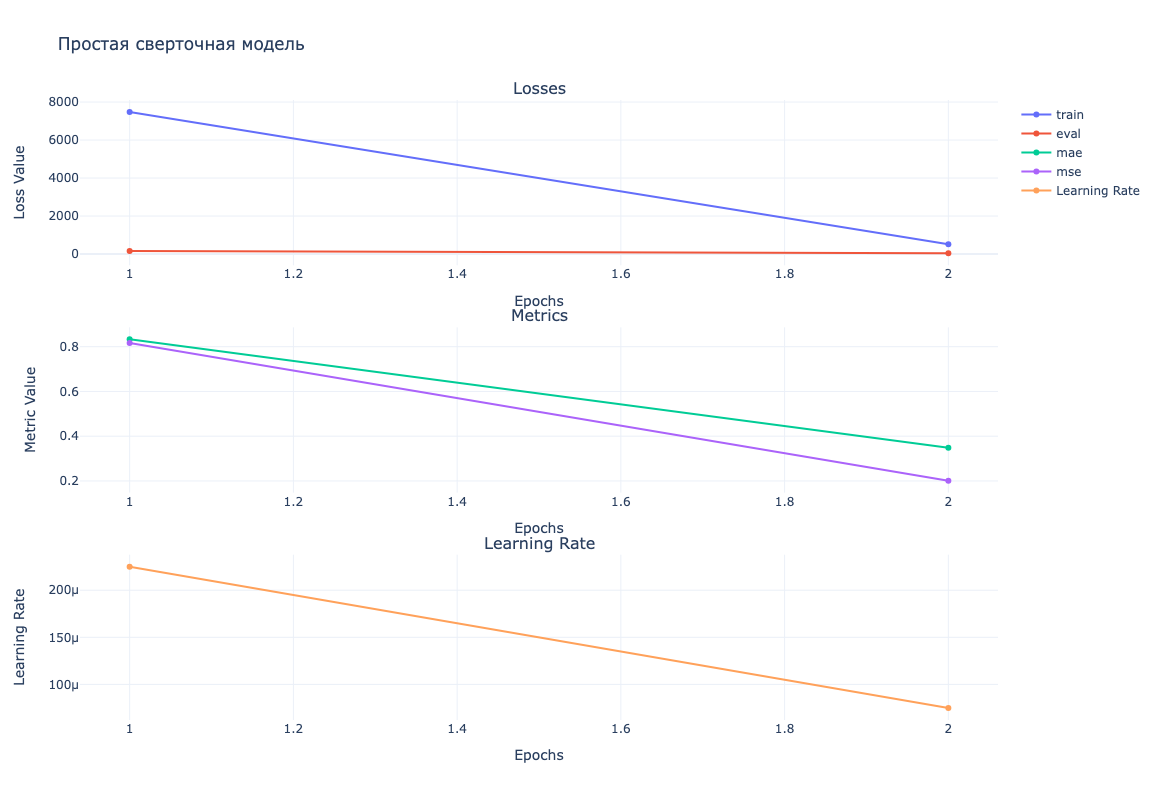

------------------------
Training epoch 3


100%|█████████▉| 764/764.8984375 [01:03<00:00, 12.23it/s]/home/jupyter/.local/lib/python3.10/site-packages/tqdm/std.py:636: TqdmWarning:

clamping frac to range [0, 1]

100%|██████████| 765/764.8984375 [01:03<00:00, 12.03it/s]


end of training epoch 3, it took 63.59870648384094238281 seconds
Eval epoch 3


192it [00:08, 22.57it/s]                                 

end of eval epoch 3, it took 8.51131176948547363281 seconds
[0.000225, 7.500000000000003e-05, 0.0] 3 this is lr


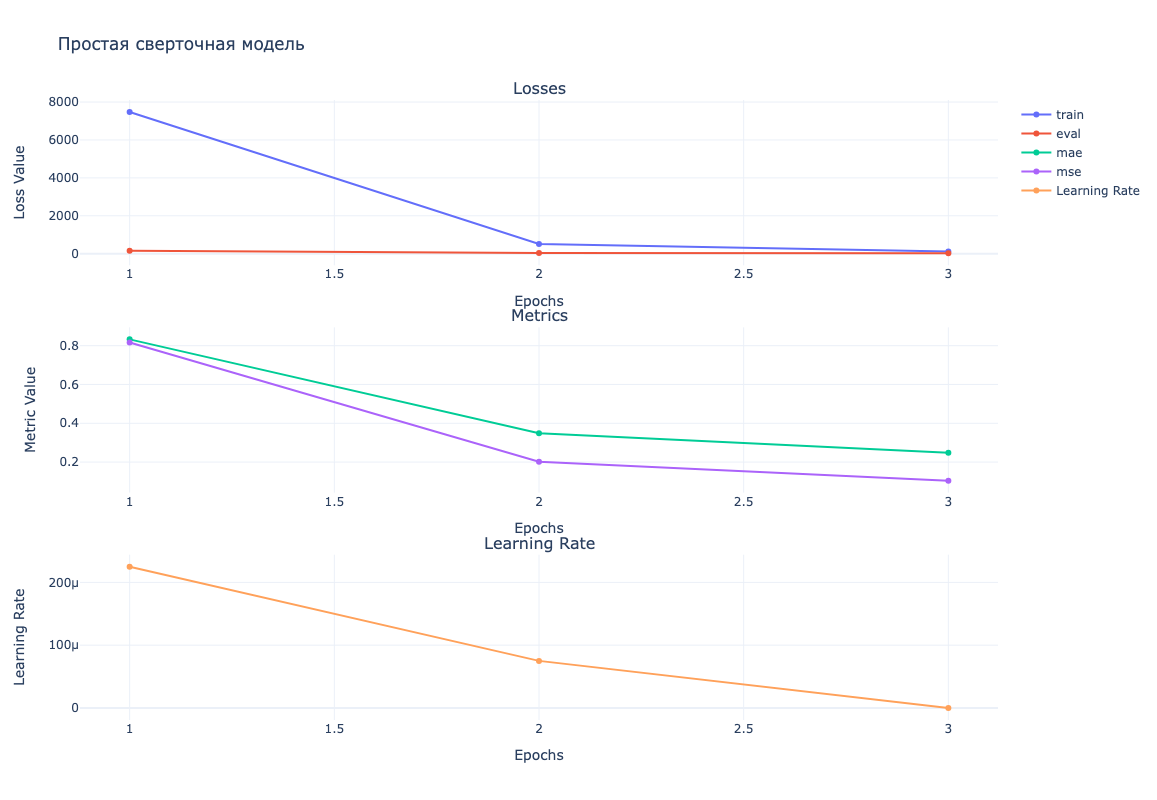

------------------------
Training epoch 4


100%|█████████▉| 764/764.8984375 [01:03<00:00, 12.29it/s]/home/jupyter/.local/lib/python3.10/site-packages/tqdm/std.py:636: TqdmWarning:

clamping frac to range [0, 1]

100%|██████████| 765/764.8984375 [01:03<00:00, 12.01it/s]


end of training epoch 4, it took 63.69075584411621093750 seconds
Eval epoch 4


192it [00:08, 22.56it/s]                                 

end of eval epoch 4, it took 8.51496434211730957031 seconds
[0.000225, 7.500000000000003e-05, 0.0, 7.499999999999998e-05] 4 this is lr


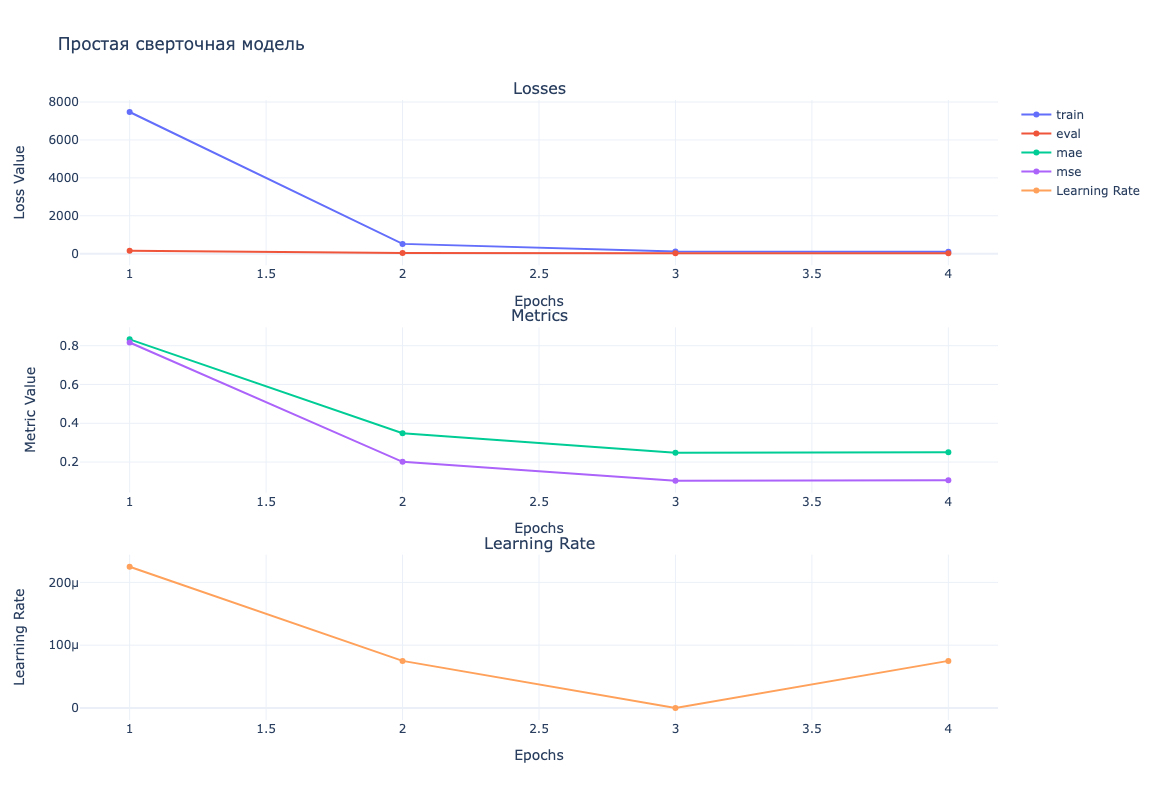

------------------------
Training epoch 5


100%|█████████▉| 764/764.8984375 [01:03<00:00, 12.15it/s]/home/jupyter/.local/lib/python3.10/site-packages/tqdm/std.py:636: TqdmWarning:

clamping frac to range [0, 1]

100%|██████████| 765/764.8984375 [01:03<00:00, 11.95it/s]


end of training epoch 5, it took 63.99884724617004394531 seconds
Eval epoch 5


192it [00:08, 22.25it/s]                                 

end of eval epoch 5, it took 8.63361525535583496094 seconds
[0.000225, 7.500000000000003e-05, 0.0, 7.499999999999998e-05, 0.00022500000000000013] 5 this is lr


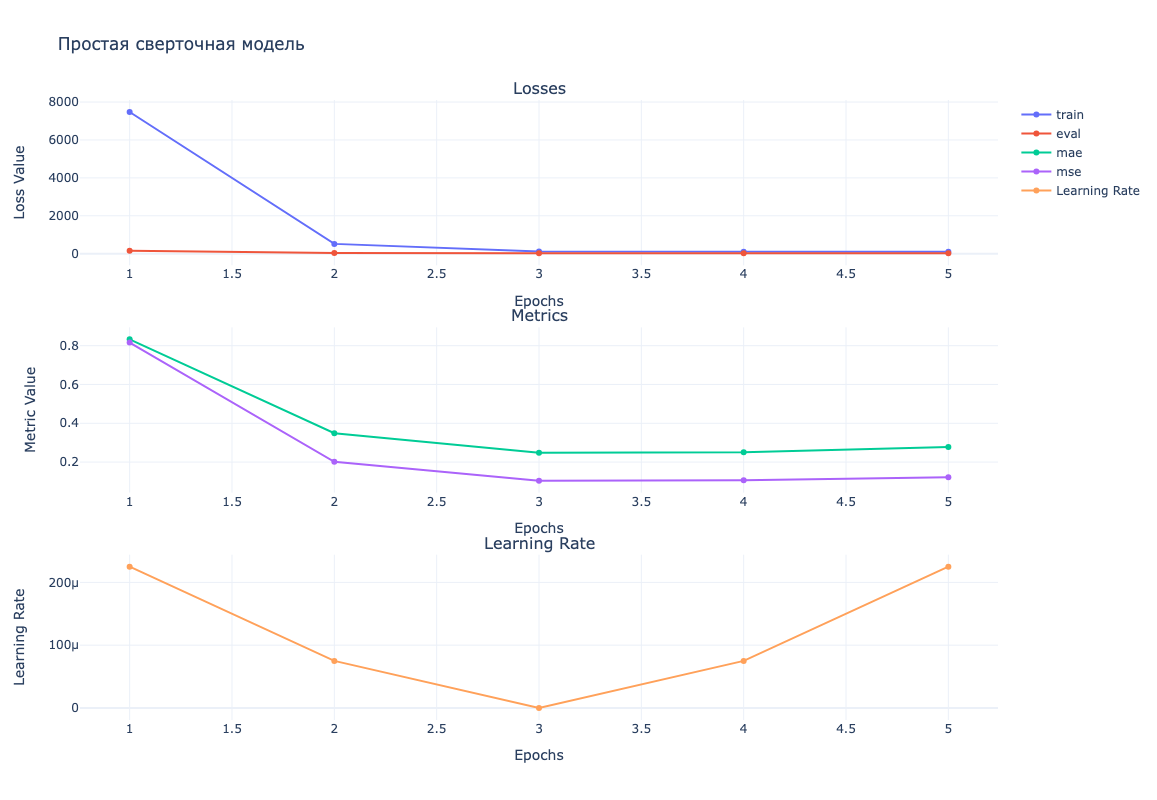

------------------------
Training epoch 6


100%|█████████▉| 764/764.8984375 [01:04<00:00, 12.08it/s]/home/jupyter/.local/lib/python3.10/site-packages/tqdm/std.py:636: TqdmWarning:

clamping frac to range [0, 1]

100%|██████████| 765/764.8984375 [01:04<00:00, 11.94it/s]


end of training epoch 6, it took 64.09966874122619628906 seconds
Eval epoch 6


192it [00:08, 22.05it/s]                                 

end of eval epoch 6, it took 8.70938253402709960938 seconds
[0.000225, 7.500000000000003e-05, 0.0, 7.499999999999998e-05, 0.00022500000000000013, 0.00030000000000000014] 6 this is lr


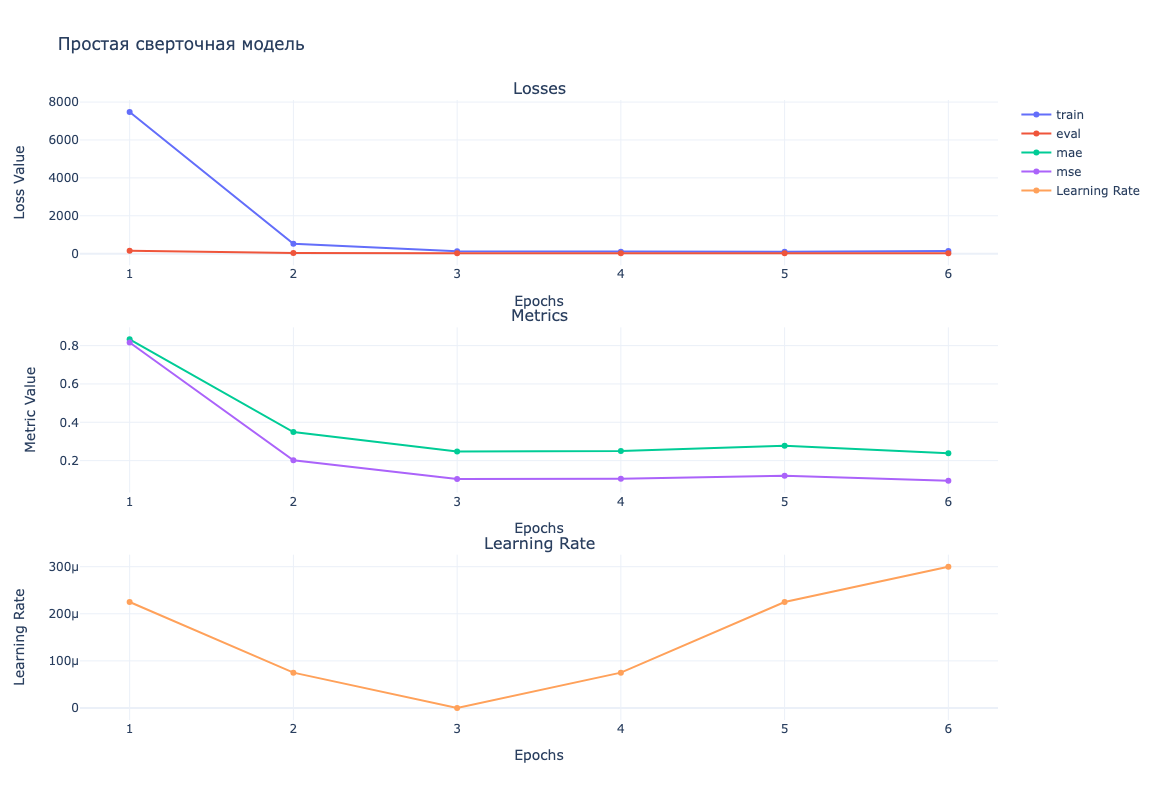

------------------------
Training epoch 7


100%|█████████▉| 764/764.8984375 [01:03<00:00, 12.12it/s]/home/jupyter/.local/lib/python3.10/site-packages/tqdm/std.py:636: TqdmWarning:

clamping frac to range [0, 1]

100%|██████████| 765/764.8984375 [01:04<00:00, 11.94it/s]


end of training epoch 7, it took 64.04766082763671875000 seconds
Eval epoch 7


192it [00:08, 22.21it/s]                                 

end of eval epoch 7, it took 8.64861369132995605469 seconds
[0.000225, 7.500000000000003e-05, 0.0, 7.499999999999998e-05, 0.00022500000000000013, 0.00030000000000000014, 0.00022500000000000016] 7 this is lr


------------------------
Training epoch 8


100%|█████████▉| 764/764.8984375 [01:03<00:00, 12.22it/s]/home/jupyter/.local/lib/python3.10/site-packages/tqdm/std.py:636: TqdmWarning:

clamping frac to range [0, 1]

100%|██████████| 765/764.8984375 [01:03<00:00, 11.96it/s]


end of training epoch 8, it took 63.97125864028930664062 seconds
Eval epoch 8


192it [00:08, 22.39it/s]                                 

end of eval epoch 8, it took 8.57825326919555664062 seconds
[0.000225, 7.500000000000003e-05, 0.0, 7.499999999999998e-05, 0.00022500000000000013, 0.00030000000000000014, 0.00022500000000000016, 7.500000000000014e-05] 8 this is lr


------------------------
Training epoch 9


100%|█████████▉| 764/764.8984375 [01:03<00:00, 12.27it/s]/home/jupyter/.local/lib/python3.10/site-packages/tqdm/std.py:636: TqdmWarning:

clamping frac to range [0, 1]

100%|██████████| 765/764.8984375 [01:03<00:00, 12.02it/s]


end of training epoch 9, it took 63.63221931457519531250 seconds
Eval epoch 9


192it [00:08, 22.69it/s]                                 

end of eval epoch 9, it took 8.46723628044128417969 seconds
[0.000225, 7.500000000000003e-05, 0.0, 7.499999999999998e-05, 0.00022500000000000013, 0.00030000000000000014, 0.00022500000000000016, 7.500000000000014e-05, 0.0] 9 this is lr


------------------------
Training epoch 10


100%|█████████▉| 764/764.8984375 [01:03<00:00, 12.26it/s]/home/jupyter/.local/lib/python3.10/site-packages/tqdm/std.py:636: TqdmWarning:

clamping frac to range [0, 1]

100%|██████████| 765/764.8984375 [01:03<00:00, 12.03it/s]


end of training epoch 10, it took 63.61459326744079589844 seconds
Eval epoch 10


192it [00:08, 22.58it/s]                                 

end of eval epoch 10, it took 8.50593614578247070312 seconds
[0.000225, 7.500000000000003e-05, 0.0, 7.499999999999998e-05, 0.00022500000000000013, 0.00030000000000000014, 0.00022500000000000016, 7.500000000000014e-05, 0.0, 7.499999999999998e-05] 10 this is lr


In [87]:
model = CNN_model_and_dropout()

loss = nn.MSELoss('sum')
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4)
lr_scheduler = CosineAnnealingLR(optimizer, 3)

losses, metrics = model_training(model, loss, optimizer, device, lr_scheduler, num_epochs=10)

# Bidirectional recurrent + pretrained_embeds

In [25]:
class model_bidirectional(nn.Module):
    def __init__(self, emb_size=300, hidden_size=256, categorial_size=3768):
        super().__init__()
        self.embed_size = emb_size
        self.hidden_size = hidden_size
        self.categorial_size = categorial_size
        
        self.emdeddings = nn.Embedding.from_pretrained(pretrained_weights, freeze=False, padding_idx=token_to_id['PAD'])
        self.bidirectional_LSTM = nn.LSTM(input_size=self.embed_size, hidden_size = self.hidden_size//2, num_layers=1, bias=False, batch_first=True, 
                                         bidirectional=True)
        
        self.categorial_extractor = nn.Sequential(OrderedDict([
            ('linear1', nn.Linear(self.categorial_size, 1000)),
            ('ReLU', nn.ReLU()),
            ('linear2', nn.Linear(1000, self.hidden_size))
        ])
        )
        
        self.fc = nn.Sequential(OrderedDict([
            ('linear1', nn.Linear(3 * self.hidden_size, 1000)),
            ('batchnorm', nn.BatchNorm1d(1000)),
            ('ReLU', nn.ReLU()),
            ('dropout', nn.Dropout1d(p=0.2)),
            ('linear2', nn.Linear(1000, 50))
        ])
        )
        
    def forward(self, x):
        features_title = self.bidirectional_LSTM(self.emdeddings(x['Title']))[1][0]
        features_description = self.bidirectional_LSTM(self.emdeddings(x['FullDescription']))[1][0]
        features_categorial = self.categorial_extractor(x['Categorical'])
        
        features_description = features_description.permute(1, 0, 2).contiguous().view(x['Title'].shape[0], self. hidden_size)
        features_title = features_title.permute(1, 0, 2).contiguous().view(x['Title'].shape[0], self. hidden_size)
        
        features = torch.cat([features_title, features_description, features_categorial], dim=-1)
        result = self.fc(features)
        
        return result.sum(dim=-1)

/home/jupyter/.local/lib/python3.10/site-packages/torch/nn/_reduction.py:42: UserWarning:

size_average and reduce args will be deprecated, please use reduction='mean' instead.



------------------------
Training epoch 1


100%|█████████▉| 764/764.8984375 [00:52<00:00, 14.89it/s]/home/jupyter/.local/lib/python3.10/site-packages/tqdm/std.py:636: TqdmWarning:

clamping frac to range [0, 1]

100%|██████████| 765/764.8984375 [00:52<00:00, 14.51it/s]


end of training epoch 1, it took 52.71798157691955566406 seconds
Eval epoch 1


192it [00:07, 24.42it/s]                                 

end of eval epoch 1, it took 7.86633968353271484375 seconds
[0.00029265847744427303] 1 this is lr


------------------------
Training epoch 2


100%|█████████▉| 764/764.8984375 [00:52<00:00, 15.07it/s]/home/jupyter/.local/lib/python3.10/site-packages/tqdm/std.py:636: TqdmWarning:

clamping frac to range [0, 1]

100%|██████████| 765/764.8984375 [00:52<00:00, 14.48it/s]


end of training epoch 2, it took 52.82041788101196289062 seconds
Eval epoch 2


192it [00:07, 24.44it/s]                                 

end of eval epoch 2, it took 7.85919356346130371094 seconds
[0.00029265847744427303, 0.0002713525491562421] 2 this is lr


------------------------
Training epoch 3


100%|█████████▉| 764/764.8984375 [00:52<00:00, 14.87it/s]/home/jupyter/.local/lib/python3.10/site-packages/tqdm/std.py:636: TqdmWarning:

clamping frac to range [0, 1]

100%|██████████| 765/764.8984375 [00:52<00:00, 14.46it/s]


end of training epoch 3, it took 52.90783500671386718750 seconds
Eval epoch 3


192it [00:07, 24.37it/s]                                 

end of eval epoch 3, it took 7.87919735908508300781 seconds
[0.00029265847744427303, 0.0002713525491562421, 0.00023816778784387096] 3 this is lr


------------------------
Training epoch 4


100%|█████████▉| 764/764.8984375 [00:52<00:00, 14.83it/s]/home/jupyter/.local/lib/python3.10/site-packages/tqdm/std.py:636: TqdmWarning:

clamping frac to range [0, 1]

100%|██████████| 765/764.8984375 [00:52<00:00, 14.45it/s]


end of training epoch 4, it took 52.93333268165588378906 seconds
Eval epoch 4


192it [00:07, 24.38it/s]                                 

end of eval epoch 4, it took 7.87688994407653808594 seconds
[0.00029265847744427303, 0.0002713525491562421, 0.00023816778784387096, 0.0001963525491562421] 4 this is lr


------------------------
Training epoch 5


100%|█████████▉| 764/764.8984375 [00:52<00:00, 14.98it/s]/home/jupyter/.local/lib/python3.10/site-packages/tqdm/std.py:636: TqdmWarning:

clamping frac to range [0, 1]

100%|██████████| 765/764.8984375 [00:52<00:00, 14.48it/s]


end of training epoch 5, it took 52.81684541702270507812 seconds
Eval epoch 5


192it [00:07, 24.35it/s]                                 

end of eval epoch 5, it took 7.88811326026916503906 seconds
[0.00029265847744427303, 0.0002713525491562421, 0.00023816778784387096, 0.0001963525491562421, 0.00015] 5 this is lr


------------------------
Training epoch 6


100%|█████████▉| 764/764.8984375 [00:52<00:00, 15.10it/s]/home/jupyter/.local/lib/python3.10/site-packages/tqdm/std.py:636: TqdmWarning:

clamping frac to range [0, 1]

100%|██████████| 765/764.8984375 [00:52<00:00, 14.50it/s]


end of training epoch 6, it took 52.76818037033081054688 seconds
Eval epoch 6


192it [00:07, 24.28it/s]                                 

end of eval epoch 6, it took 7.91081643104553222656 seconds
[0.00029265847744427303, 0.0002713525491562421, 0.00023816778784387096, 0.0001963525491562421, 0.00015, 0.0001036474508437579] 6 this is lr


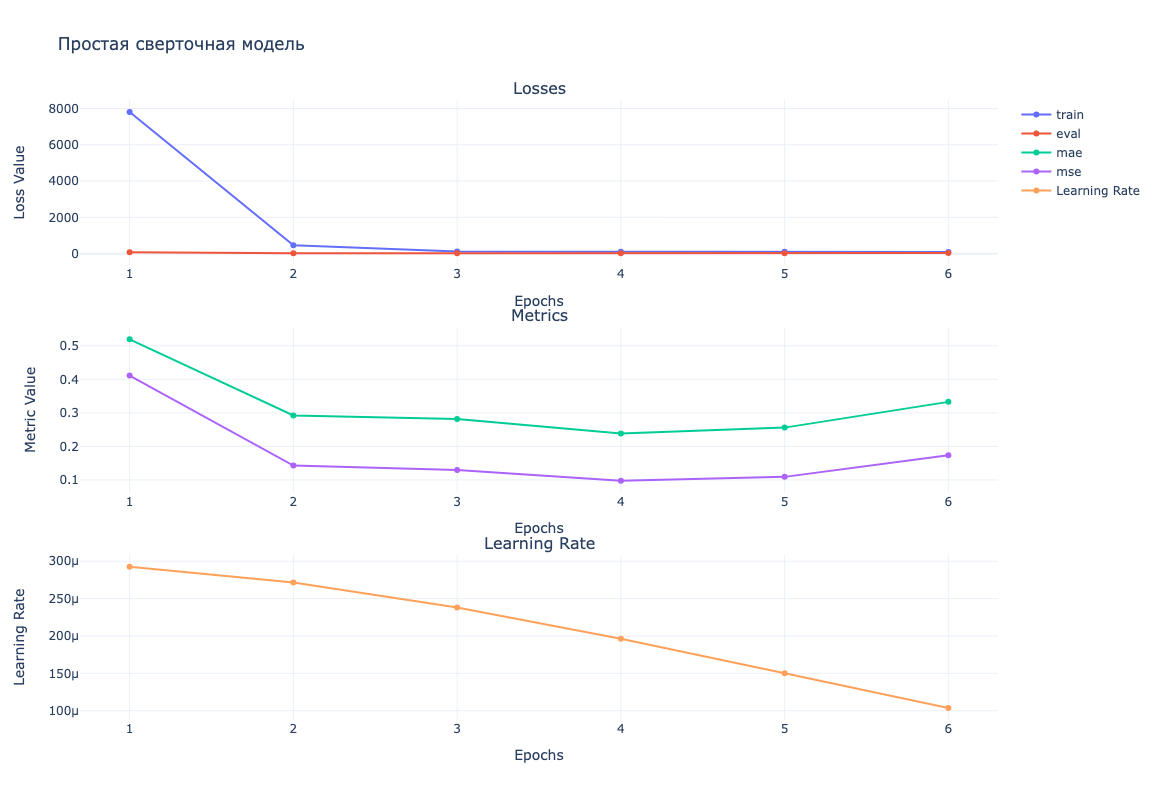

------------------------
Training epoch 7


100%|█████████▉| 764/764.8984375 [00:52<00:00, 14.88it/s]/home/jupyter/.local/lib/python3.10/site-packages/tqdm/std.py:636: TqdmWarning:

clamping frac to range [0, 1]

100%|██████████| 765/764.8984375 [00:52<00:00, 14.46it/s]


end of training epoch 7, it took 52.92050743103027343750 seconds
Eval epoch 7


192it [00:07, 24.36it/s]                                 

end of eval epoch 7, it took 7.88324642181396484375 seconds
[0.00029265847744427303, 0.0002713525491562421, 0.00023816778784387096, 0.0001963525491562421, 0.00015, 0.0001036474508437579, 6.183221215612905e-05] 7 this is lr


------------------------
Training epoch 8


100%|█████████▉| 764/764.8984375 [00:52<00:00, 14.87it/s]/home/jupyter/.local/lib/python3.10/site-packages/tqdm/std.py:636: TqdmWarning:

clamping frac to range [0, 1]

100%|██████████| 765/764.8984375 [00:52<00:00, 14.47it/s]


end of training epoch 8, it took 52.86800646781921386719 seconds
Eval epoch 8


192it [00:07, 24.39it/s]                                 

end of eval epoch 8, it took 7.87323808670043945312 seconds
[0.00029265847744427303, 0.0002713525491562421, 0.00023816778784387096, 0.0001963525491562421, 0.00015, 0.0001036474508437579, 6.183221215612905e-05, 2.86474508437579e-05] 8 this is lr


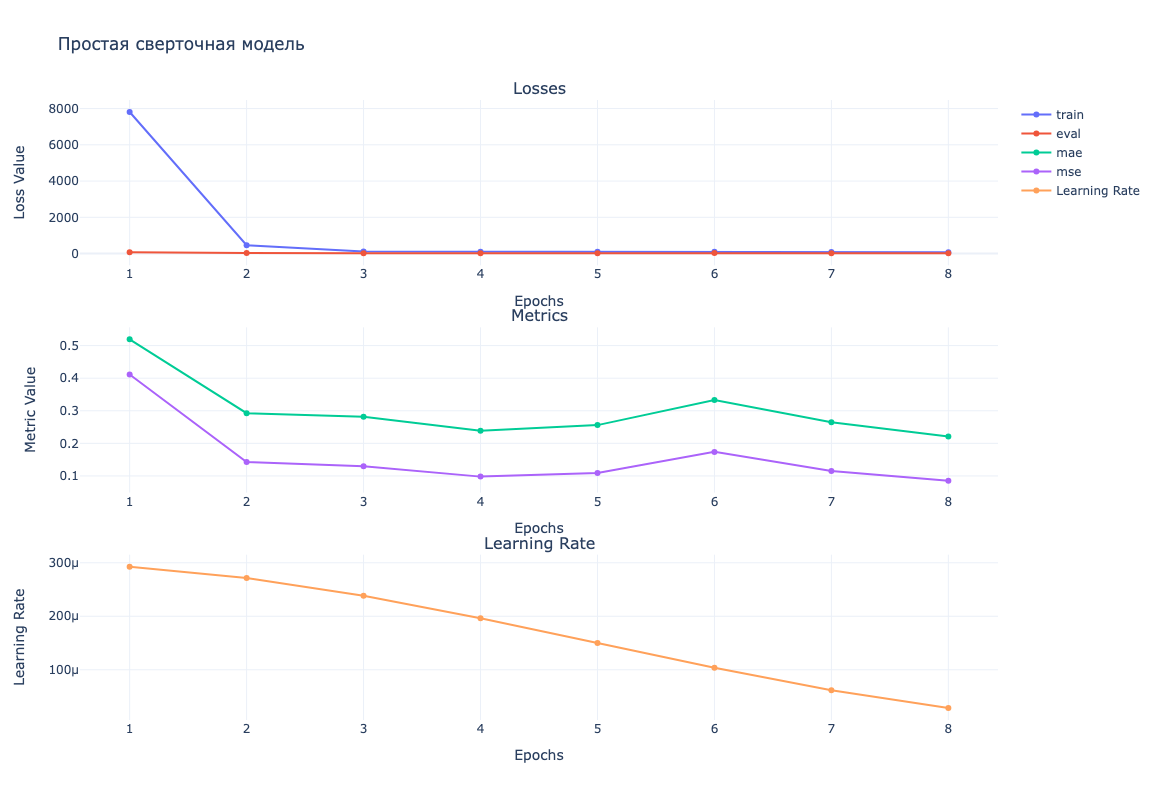

------------------------
Training epoch 9


100%|█████████▉| 764/764.8984375 [00:52<00:00, 14.67it/s]/home/jupyter/.local/lib/python3.10/site-packages/tqdm/std.py:636: TqdmWarning:

clamping frac to range [0, 1]

100%|██████████| 765/764.8984375 [00:52<00:00, 14.48it/s]


end of training epoch 9, it took 52.84441757202148437500 seconds
Eval epoch 9


192it [00:07, 24.49it/s]                                 

end of eval epoch 9, it took 7.84321355819702148438 seconds
[0.00029265847744427303, 0.0002713525491562421, 0.00023816778784387096, 0.0001963525491562421, 0.00015, 0.0001036474508437579, 6.183221215612905e-05, 2.86474508437579e-05, 7.341522555726971e-06] 9 this is lr


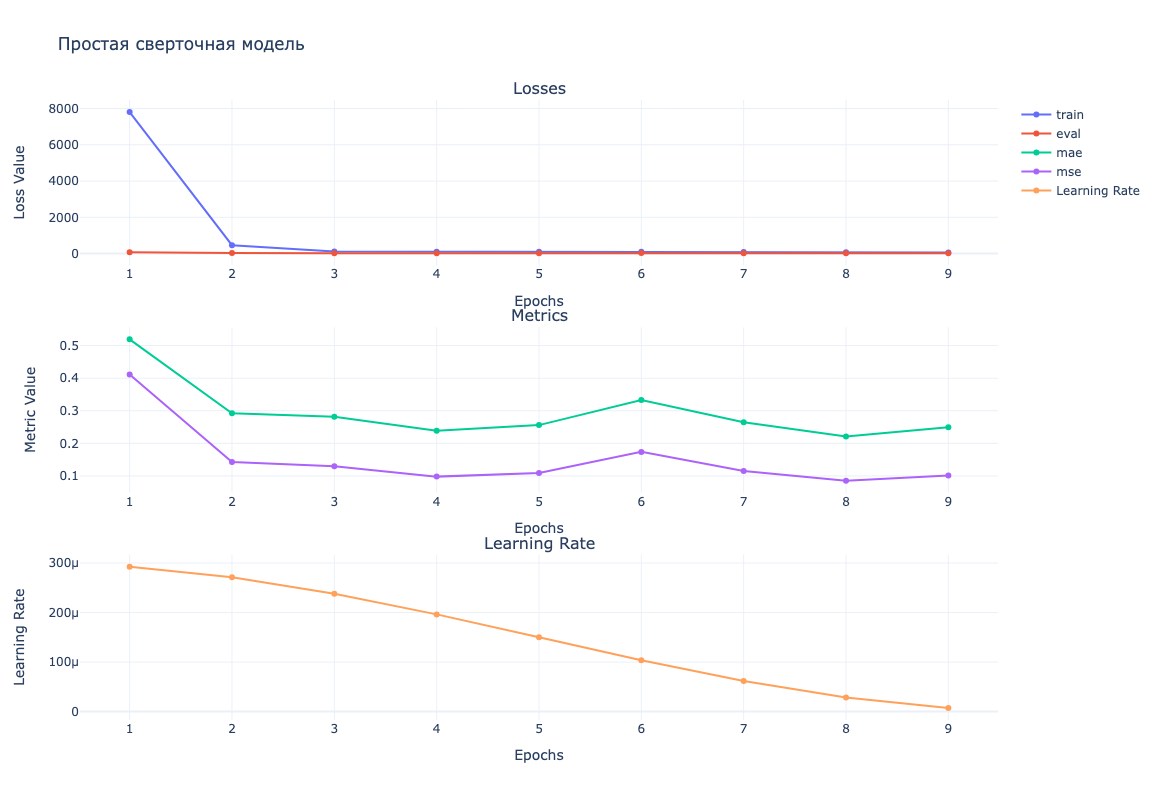

------------------------
Training epoch 10


100%|█████████▉| 764/764.8984375 [00:52<00:00, 14.69it/s]/home/jupyter/.local/lib/python3.10/site-packages/tqdm/std.py:636: TqdmWarning:

clamping frac to range [0, 1]

100%|██████████| 765/764.8984375 [00:52<00:00, 14.44it/s]


end of training epoch 10, it took 52.97777915000915527344 seconds
Eval epoch 10


192it [00:07, 24.16it/s]                                 

end of eval epoch 10, it took 7.94937968254089355469 seconds
[0.00029265847744427303, 0.0002713525491562421, 0.00023816778784387096, 0.0001963525491562421, 0.00015, 0.0001036474508437579, 6.183221215612905e-05, 2.86474508437579e-05, 7.341522555726971e-06, 0.0] 10 this is lr


In [29]:
model = model_bidirectional()

loss = nn.MSELoss('sum')
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4)
lr_scheduler = CosineAnnealingLR(optimizer, T_max=10)

losses, metrics = model_training(model, loss, optimizer, device, lr_scheduler, num_epochs=10)